<a href="https://colab.research.google.com/github/22116001/Classification_CIFAR_10/blob/main/Galaxy_Prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from torch.optim import lr_scheduler
import torch.nn.functional as F
import time
from tempfile import TemporaryDirectory
from torchvision.models import resnet50, ResNet50_Weights
import os
import copy
from skimage.measure import block_reduce
from PIL import Image

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Galaxy prediction/images.npy'
loaded_data = np.load(file_path)

In [ ]:
labels_path = '/content/drive/MyDrive/Galaxy prediction/labels.npy'
labels_data = np.load(labels_path)

In [ ]:
loaded_data.shape

(17736, 256, 256, 3)

In [ ]:
labels_data.shape

(17736,)

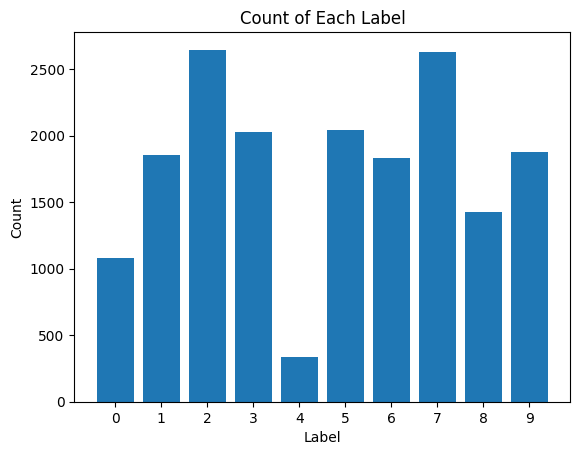

In [ ]:
label_counts = np.bincount(labels_data)

plt.bar(np.arange(10), label_counts, tick_label=np.arange(10))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.show()

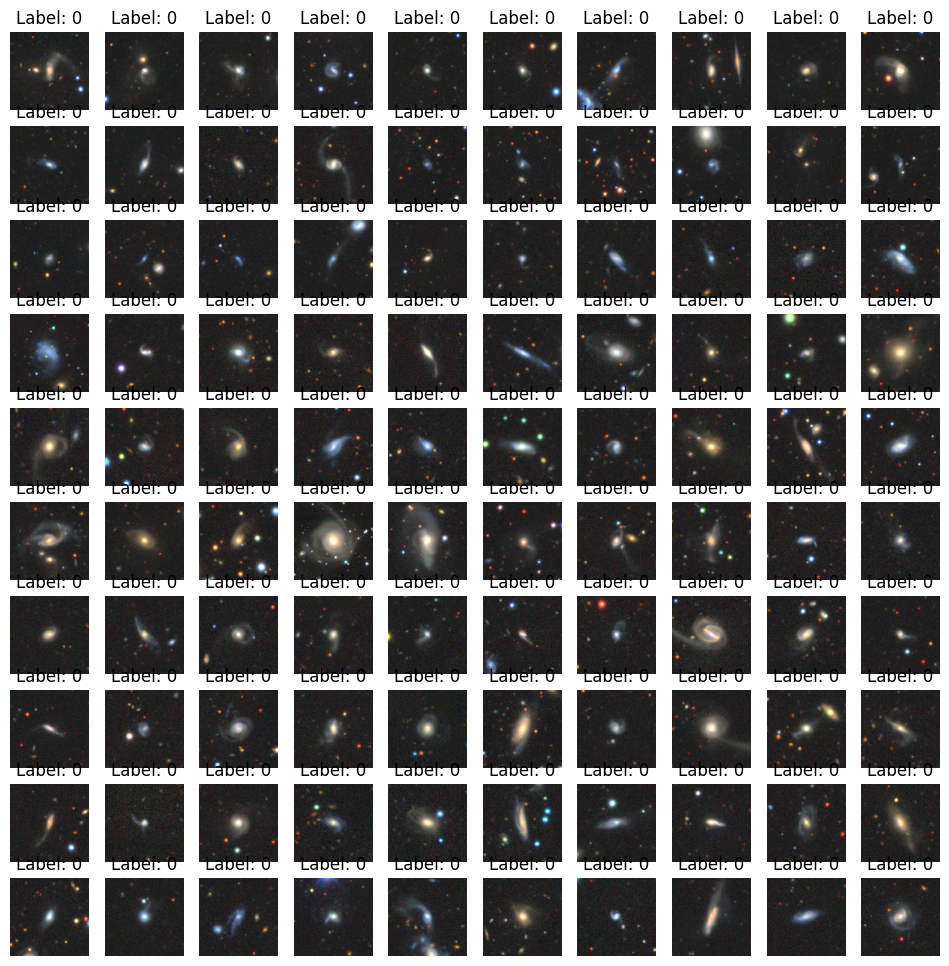

In [ ]:
num_images_to_display = 100
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
for i in range(num_images_to_display):
    ax = axes[i // 10, i % 10]
    ax.imshow(loaded_data[i])
    ax.axis('off')
    ax.set_title(f"Label: {labels_data[i]}")

plt.show()

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [ ]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy.ndarray): The 4D numpy array of images.
            labels (numpy.ndarray): The corresponding labels for the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image
        image = Image.fromarray(image)

        # If a transform is provided, apply it
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from sklearn.model_selection import train_test_split

# Split into 80% training and 20% validation
train_images, valid_images, train_labels, valid_labels = train_test_split(loaded_data, labels_data, test_size=0.2, random_state=42)

In [ ]:
# Create custom datasets for training and validation
train_dataset = CustomImageDataset(train_images, train_labels, transform=data_transforms['train'])
valid_dataset = CustomImageDataset(valid_images, valid_labels, transform=data_transforms['validation'])

In [ ]:
batch_size = 32
# DataLoader for batching and shuffling for both training and validation
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch in train_dataloader:
    data, labels = batch

    print(data.shape)
    break

torch.Size([32, 3, 224, 224])


In [ ]:

model= models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


In [ ]:
model = model.to(device)

In [ ]:

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            dataloaders = train_dataloader if phase == 'train' else valid_dataloader
            dataset_size = len(dataloaders.dataset)
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model = model.to(device)

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,device,num_epochs=15)

Epoch 0/14
----------
train Loss: 1.4058 Acc: 0.5216
val Loss: 0.8285 Acc: 0.7153

Epoch 1/14
----------
train Loss: 0.7256 Acc: 0.7530
val Loss: 0.5912 Acc: 0.8033

Epoch 2/14
----------
train Loss: 0.6141 Acc: 0.7890
val Loss: 0.5187 Acc: 0.8272

Epoch 3/14
----------
train Loss: 0.5417 Acc: 0.8124
val Loss: 0.4993 Acc: 0.8303

Epoch 4/14
----------
train Loss: 0.4838 Acc: 0.8382
val Loss: 0.4949 Acc: 0.8346

Epoch 5/14
----------
train Loss: 0.4458 Acc: 0.8460
val Loss: 0.5054 Acc: 0.8337

Epoch 6/14
----------
train Loss: 0.4218 Acc: 0.8565
val Loss: 0.4660 Acc: 0.8419

Epoch 7/14
----------
train Loss: 0.3472 Acc: 0.8821
val Loss: 0.4179 Acc: 0.8625

Epoch 8/14
----------
train Loss: 0.3337 Acc: 0.8860
val Loss: 0.4204 Acc: 0.8641

Epoch 9/14
----------
train Loss: 0.3199 Acc: 0.8907
val Loss: 0.4189 Acc: 0.8613

Epoch 10/14
----------
train Loss: 0.3123 Acc: 0.8944
val Loss: 0.4090 Acc: 0.8639

Epoch 11/14
----------
train Loss: 0.3052 Acc: 0.8948
val Loss: 0.4119 Acc: 0.8644

Ep